<a href="https://colab.research.google.com/github/hamsterjoa/Kbank_playstore_review_analysis/blob/master/Sentiment_by_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys  
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install customized_konlpy

In [33]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter

from konlpy.tag import Okt; t=Okt()
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 데이터 로드

In [5]:
# 파일 불러오기
test_data = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/test_data_for_modeling.pkl")
train_data = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/train_data_for_modeling.pkl")

In [28]:
# 중복을 제외한 샘플의 수
train_data['content'].nunique(), train_data['label'].nunique()

(1530, 2)

In [29]:
train_data.drop_duplicates(subset=['content'], inplace=True)
print('총 샘플의 수 : ', len(train_data))

총 샘플의 수 :  1530


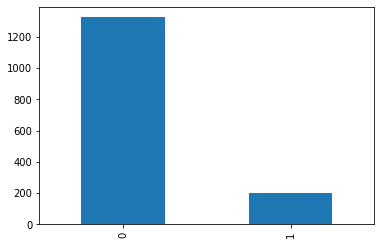

In [30]:
# 훈련 데이터의 레이블 분포
train_data['label'].value_counts().plot(kind='bar')

In [31]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0   1326
1      1    204


전체 리뷰 중에 부정리뷰가 약 87%, 긍정리뷰가 약 13%를 차지하고 있습니다.

## 단어와 길이 및 분포 확인

In [6]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [7]:
# 부정 리뷰에 대해서 빈도수가 높은 상위 20개 단어 출력
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('인증', 323), ('다시', 273), ('계좌', 272), ('계속', 227), ('사용', 220), ('화면', 217), ('신분증', 217), ('인식', 182), ('설치', 175), ('가입', 171), ('접속', 168), ('확인', 163), ('실행', 159), ('이체', 152), ('오류', 132), ('로그인', 127), ('너무', 127), ('삭제', 124), ('진짜', 122), ('등록', 121)]


In [8]:
# 긍정 리뷰에 대해서 빈도수가 높은 상위 20개 단어 출력
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('사용', 54), ('좋아요', 32), ('너무', 30), ('계좌', 26), ('알림', 21), ('이용', 21), ('수수료', 19), ('이체', 19), ('카드', 19), ('업데이트', 18), ('인증', 17), ('다시', 17), ('편하고', 16), ('인식', 15), ('설치', 14), ('깔끔하고', 14), ('뱅킹', 13), ('폰', 13), ('인증서', 13), ('가입', 13)]


긍정 리뷰의 평균 길이 : 18.622549019607842
부정 리뷰의 평균 길이 : 23.206636500754147


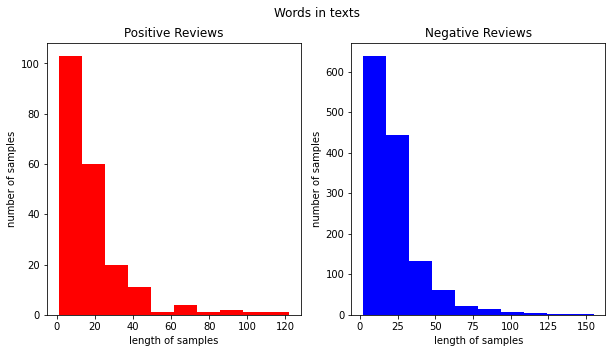

In [9]:
# 두 가지 경우에 대해서 각각 길이 분포 확인
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [10]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

## 정수 인코딩

In [11]:
# 훈련 데이터에 대해서 단어 집합(vocaburary) 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [12]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 7248
등장 빈도가 1번 이하인 희귀 단어의 수: 4231
단어 집합에서 희귀 단어의 비율: 58.374724061810156
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 12.238581470018223


약 7,248개의 단어가 존재합니다. 등장 빈도가 1회인 단어들은 단어 집합에서 약 58%를 차지하지만, 실제 훈련 데이터에서 등장 빈도로 차지하는 비중은 12%로 이 단어들은 정수 인코딩 과정에서 배제시키겠습니다.

In [13]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 3019


In [14]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [15]:
# 상위 3개 샘플 확인
print(X_train[:3])
print(X_test[:3])

[[1, 18, 239, 369, 1, 160, 2, 4, 47, 126, 54, 1549, 32, 88, 151, 1], [293, 25, 739, 73, 1088, 2021, 1268, 44, 269, 1, 1, 76, 620, 544, 673, 181], [417, 370, 836, 71, 59, 56, 85, 7, 1, 59, 161, 837, 1550, 2022, 1269, 347, 1, 674, 508, 281, 56, 1, 1270, 162, 202, 838, 59, 545, 1, 215, 54, 281, 1, 89, 1, 1271, 13, 1, 325, 2023, 1272, 98, 1551, 1, 59, 545, 1, 2024, 59, 545, 1552, 481, 50, 371, 112, 1, 149, 59, 545, 59, 1, 1, 326, 1273, 281, 34, 1, 943, 1, 1]]
[[135, 9, 137, 1, 202, 313, 647, 1], [8, 9, 1, 1, 61, 2010, 611, 50, 70, 9, 1, 65, 131, 30, 687, 1885, 1303, 215, 1751], [2859, 408, 1, 371, 1, 260, 1936, 94, 1060, 3, 1685, 88, 1370, 1, 7, 1, 1357, 642, 8, 118, 1, 1155, 30, 801, 3, 259, 1, 1, 116, 73, 785, 73, 1, 1806, 1, 1, 1, 1, 1, 1, 90, 2809, 1, 1382, 2818, 679, 1, 1]]


## 패딩

리뷰의 최대 길이 : 155
리뷰의 평균 길이 : 22.595424836601307


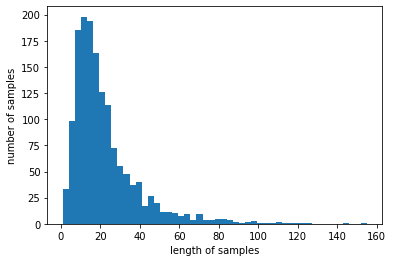

In [16]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

최대 길이가 155이므로 만약 100으로 패딩할 경우, 몇 개의 샘플들을 온전히 보전할 수 있을지 확인합니다.

In [18]:
max_len = 100
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 100 이하인 샘플의 비율: 99.2156862745098


In [19]:
# 훈련용 리뷰를 길이 100으로 패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

## **GRU로 감성 분류**

In [34]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
20/20 [==============================] - ETA: 0s - loss: 0.4928 - acc: 0.8497
Epoch 1: val_acc improved from -inf to 0.86275, saving model to best_model.h5
20/20 [==============================] - 10s 267ms/step - loss: 0.4928 - acc: 0.8497 - val_loss: 0.3460 - val_acc: 0.8627
Epoch 2/15
20/20 [==============================] - ETA: 0s - loss: 0.2753 - acc: 0.8889
Epoch 2: val_acc improved from 0.86275 to 0.89542, saving model to best_model.h5
20/20 [==============================] - 4s 197ms/step - loss: 0.2753 - acc: 0.8889 - val_loss: 0.3942 - val_acc: 0.8954
Epoch 3/15
20/20 [==============================] - ETA: 0s - loss: 0.1778 - acc: 0.9232
Epoch 3: val_acc improved from 0.89542 to 0.91176, saving model to best_model.h5
20/20 [==============================] - 4s 196ms/step - loss: 0.1778 - acc: 0.9232 - val_loss: 0.3607 - val_acc: 0.9118
Epoch 4/15
20/20 [==============================] - ETA: 0s - loss: 0.1031 - acc: 0.9608
Epoch 4: val_acc did not improve from 0.

*에코프 5에서 조기 종료가 발생했습니다.*

In [35]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

16/16 [==============================] - 1s 27ms/step - loss: 0.4409 - acc: 0.8882

 테스트 정확도: 0.8882


## **BiLSTM으로 감성 분류**

In [20]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)


Epoch 1/15
5/5 [==============================] - ETA: 0s - loss: 0.6049 - acc: 0.7132
Epoch 1: val_acc improved from -inf to 0.86275, saving model to best_model.h5
5/5 [==============================] - 14s 2s/step - loss: 0.6049 - acc: 0.7132 - val_loss: 0.3981 - val_acc: 0.8627
Epoch 2/15
5/5 [==============================] - ETA: 0s - loss: 0.3829 - acc: 0.8676
Epoch 2: val_acc did not improve from 0.86275
5/5 [==============================] - 7s 1s/step - loss: 0.3829 - acc: 0.8676 - val_loss: 0.3917 - val_acc: 0.8627
Epoch 3/15
5/5 [==============================] - ETA: 0s - loss: 0.3647 - acc: 0.8676
Epoch 3: val_acc did not improve from 0.86275
5/5 [==============================] - 6s 1s/step - loss: 0.3647 - acc: 0.8676 - val_loss: 0.3731 - val_acc: 0.8627
Epoch 4/15
5/5 [==============================] - ETA: 0s - loss: 0.3226 - acc: 0.8676
Epoch 4: val_acc did not improve from 0.86275
5/5 [==============================] - 6s 1s/step - loss: 0.3226 - acc: 0.8676 - val_lo

*에포크 12에서 조기 종료가 발생했습니다.*

In [21]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

16/16 [==============================] - 2s 58ms/step - loss: 0.3504 - acc: 0.8902
테스트 정확도: 0.8902


### 리뷰 예측해보기

In [22]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게','요','거','로','으로',
            '것','수','할','하는','제','에서','그','데','번','해도','죠','된','건','바','구','세','안','하고','만','못','재','잘','하고','더','안','때','앱','어플','다른',
             '왜','좀','안되고','뱅크','케이','은행','있습니다','적','하기','입니다','중','했는데','합니다','같아요','인데','저','면','주','해서','부터','뭐','후','하는데',
             '같습니다','그리고','고']

In [23]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = t.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [24]:
sentiment_predict('앱 킬때마다 인증 다시 해야함 진짜 별로임...')

86.78% 확률로 부정 리뷰입니다.


In [25]:
sentiment_predict('너무 편하지만 가입이 불편하고 지문 인식이 잘 안됨')

69.86% 확률로 부정 리뷰입니다.


In [27]:
sentiment_predict('이체하기 편하고 쉬워서 좋아요ㅎㅎ')

66.06% 확률로 긍정 리뷰입니다.
